# Proyek Klasifikasi Gambar: Animal Dataset Classification
- **Nama:** Mohammad Al Muktabar
- **Email:** m.almuktabar11@gmail.com
- **ID Dicoding:** almuktabar

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import shutil

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, Input, BatchNormalization)
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, classification_report

# Mengabaikan peringatan
import warnings
warnings.simplefilter('ignore')

2025-07-08 09:23:43.478452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751966623.670386      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751966623.726871      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation

### Data Loading

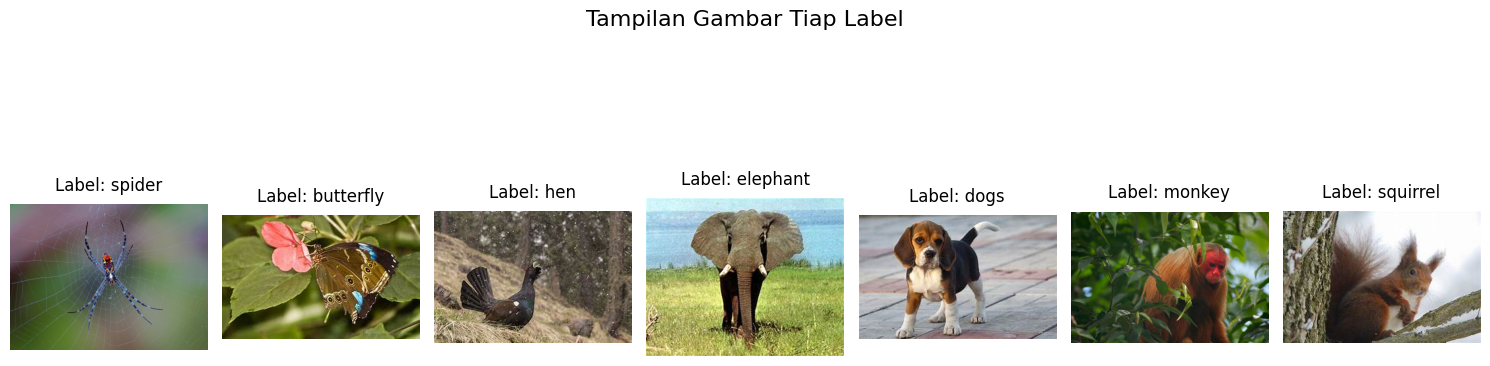

In [2]:
# Path dataset
df = "/kaggle/input/animal-datasetimg"

# Menampilkan contoh gambar pada masing-masing label dataset
label_to_images = {} # Dictionary kosong untuk menyimpan nama label sebagai key dan daftar path gambar sebagai value

for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            label = os.path.basename(root)  
            if label not in label_to_images:
                label_to_images[label] = []
            label_to_images[label].append(os.path.join(root, file))

# Memilih gambar acak dari setiap label
labels = list(label_to_images.keys())
if len(labels) > 7:
    labels = random.sample(labels, 7)  

selected_images = []
for label in labels:
    images = label_to_images[label]
    selected_images.append((label, random.choice(images)))  

plt.figure(figsize=(15, 5))
plt.suptitle("Tampilan Gambar Tiap Label", fontsize=16, y=1)  
for i, (label, img_path) in enumerate(selected_images):
    img = Image.open(img_path)
    
    plt.subplot(1, 7, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}", pad=10)  
    plt.axis('off')

plt.tight_layout()
plt.show()

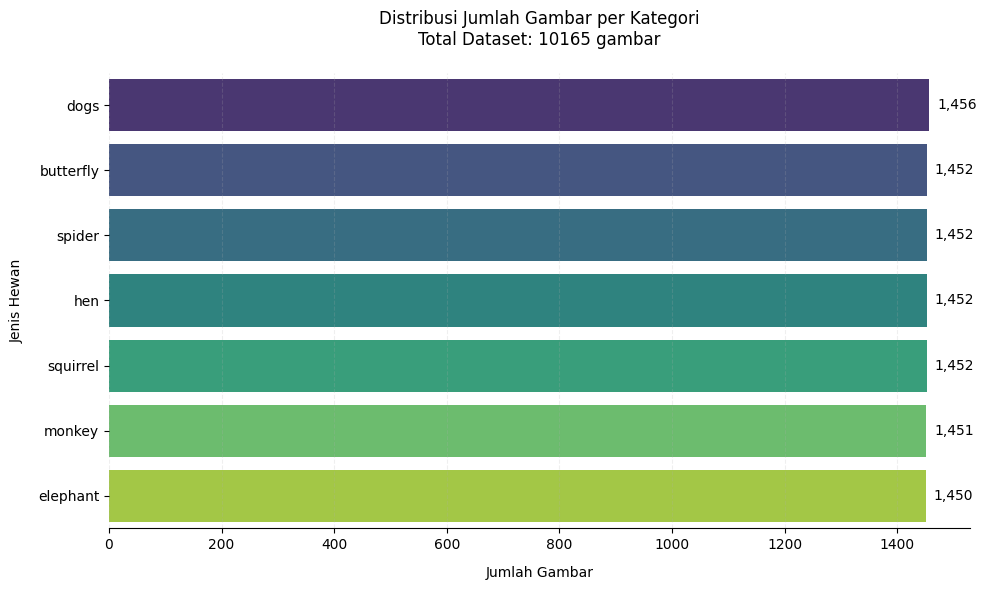

In [3]:
# Menghitung Distribusi data gambar pada setiap kategori dataset
category_counts = {}
total_images = 0  
image_paths = []

for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            label = os.path.basename(root)  
            category_counts[label] = category_counts.get(label, 0) + 1
            total_images += 1
            image_paths.append(os.path.join(root, file))

# Konversi ke DataFrame
df_counts = pd.DataFrame(list(category_counts.items()), columns=["Label", "Jumlah Gambar"])
df_counts = df_counts.sort_values("Jumlah Gambar", ascending=False)  

# Visualisasi bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_counts,
    y="Label",  
    x="Jumlah Gambar",  
    palette="viridis",  
    orient="h"  
)

# Menambahkan nilai di ujung bar
for i, value in enumerate(df_counts["Jumlah Gambar"]):
    barplot.text(
        value + max(df_counts["Jumlah Gambar"])*0.01,  
        i,  # Posisi Y
        f"{value:,}", 
        ha='left',  
        va='center',  
        fontsize=10
    )

plt.title(f"Distribusi Jumlah Gambar per Kategori\nTotal Dataset: {total_images} gambar", pad=20)
plt.xlabel("Jumlah Gambar", labelpad=10)
plt.ylabel("Jenis Hewan", labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.2)  
sns.despine(left=True)  
plt.tight_layout()
plt.show()

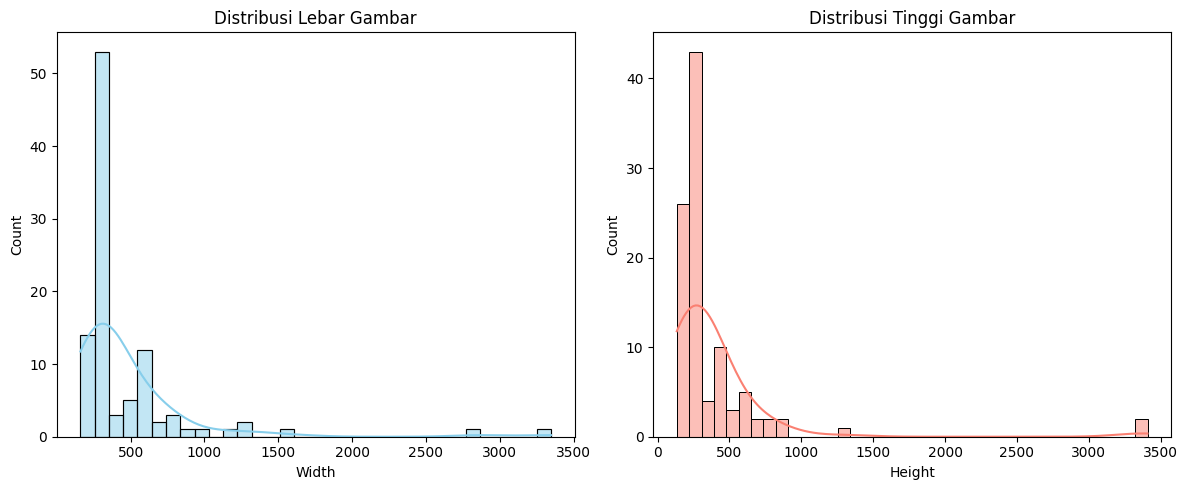

In [4]:
# Menampilkan distribusi ukuran gambar
image_sizes = []
sample_images = random.sample(image_paths, min(100, len(image_paths)))  # Hanya menggunakan 100 sampel acak gambar

for img_path in sample_images:
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # (width, height)
    except:
        continue

# Konversi ke DataFrame
df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Visualisasi distribusi ukuran
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_sizes['Width'], kde=True, color='skyblue')
plt.title("Distribusi Lebar Gambar")

plt.subplot(1, 2, 2)
sns.histplot(df_sizes['Height'], kde=True, color='salmon')
plt.title("Distribusi Tinggi Gambar")

plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [5]:
# Membuat direktori hasil split
base_dir = '/kaggle/working/animal-split' 
os.makedirs(base_dir, exist_ok=True)

# Daftar label kelas 
classes = ['butterfly', 'dogs', 'elephant', 'hen', 'monkey', 'spider', 'squirrel']

# Membuat folder struktur split
for split in ['train', 'val', 'test']:
    for class_name in classes:
        split_path = os.path.join(base_dir, split, class_name)
        os.makedirs(split_path, exist_ok=True)

# Rasio pembagian
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for class_name in classes:
    class_dir = os.path.join(df, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    train_and_val, test = train_test_split(images, test_size=test_ratio, random_state=42)
    train, val = train_test_split(train_and_val, test_size=val_ratio/(train_ratio + val_ratio), random_state=42)

    for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
        for fname in split_data:
            src = os.path.join(class_dir, fname)
            dst = os.path.join(base_dir, split_name, class_name, fname)
            shutil.copyfile(src, dst)

In [6]:
# Gunakan direktori hasil split
TRAIN_DIR = os.path.join(base_dir, 'train')
VAL_DIR = os.path.join(base_dir, 'val')
TEST_DIR = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(512, 512),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 7112 images belonging to 7 classes.
Found 1527 images belonging to 7 classes.
Found 1527 images belonging to 7 classes.


## Modelling

## EfficientNetB7

In [7]:
base_model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(512, 512, 3)
)
base_model.trainable = False

model = Sequential([
    base_model,  
    Conv2D(32, (3, 3), activation='relu'),  # Menambahkan Conv2D setelah base_model
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

I0000 00:00:1751966730.954582      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751966730.955279      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Callbacks ini mengontrol proses training di memori
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True, # Otomatis kembalikan bobot terbaik di akhir
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    mode='min',
    verbose=1
)

# Menghitung bobot kelas untuk menangani dataset yang tidak seimbang
class_indices = train_generator.classes
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(class_indices),
    y=class_indices
)
class_weights_dict = dict(enumerate(class_weights))

# --- PROSES PELATIHAN DUA TAHAP ---

# 1. TAHAP 1: MELATIH HEAD MODEL
print("--- Memulai Pelatihan Head Model ---")
base_model.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_head = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

# 2. TAHAP 2: FINE-TUNING
print("\n--- Memulai Proses Fine-Tuning ---")
base_model.trainable = True

# Bekukan hanya sebagian lapisan awal
freeze_first_n = 400
for layer in base_model.layers[:freeze_first_n]:
    layer.trainable = False

# Kompilasi ulang dengan learning rate yang sangat rendah
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Melanjutkan pelatihan untuk fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

--- Memulai Pelatihan Head Model ---
Epoch 1/50


I0000 00:00:1751966791.511984      84 service.cc:148] XLA service 0x790f90003150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751966791.512877      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751966791.512902      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751966797.909890      84 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751966807.652547      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751966807.999303      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1751966844.329905      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most onc

 48/223 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step - accuracy: 0.6064 - loss: 1.0487

E0000 00:00:1751966941.468929      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751966941.669644      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8477 - loss: 0.4439

E0000 00:00:1751967391.535170      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751967391.836568      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


223/223 ━━━━━━━━━━━━━━━━━━━━ 674s 3s/step - accuracy: 0.8481 - loss: 0.4427 - val_accuracy: 0.9935 - val_loss: 0.0555 - learning_rate: 0.0010
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.9870 - loss: 0.0516 - val_accuracy: 0.9935 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9914 - loss: 0.0307 - val_accuracy: 0.9856 - val_loss: 0.0951 - learning_rate: 0.0010
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9862 - loss: 0.0617
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
223/223 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9862 - loss: 0.0616 - val_accuracy: 0.9902 - val_loss: 0.1104 - learning_rate: 0.0010
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.9949 - loss: 0.0139 - val_accuracy: 0.9928 - val_loss: 0.0817 - learning_rate: 2.0000e-04
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.9976 - loss: 0.0130 - va

E0000 00:00:1751970053.348941      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751970053.598901      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751970056.092063      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751970056.388296      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751970058.622250      87 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

209/223 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9559 - loss: 0.1670

E0000 00:00:1751970801.773545      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751970801.937897      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751970802.765021      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751970802.944098      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751970803.767984      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

223/223 ━━━━━━━━━━━━━━━━━━━━ 1088s 4s/step - accuracy: 0.9566 - loss: 0.1644 - val_accuracy: 0.9908 - val_loss: 0.0481 - learning_rate: 1.0000e-05
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 788s 4s/step - accuracy: 0.9828 - loss: 0.0638 - val_accuracy: 0.9921 - val_loss: 0.0483 - learning_rate: 1.0000e-05
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 786s 4s/step - accuracy: 0.9902 - loss: 0.0402 - val_accuracy: 0.9941 - val_loss: 0.0482 - learning_rate: 1.0000e-05
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9929 - loss: 0.0283
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
223/223 ━━━━━━━━━━━━━━━━━━━━ 788s 4s/step - accuracy: 0.9929 - loss: 0.0283 - val_accuracy: 0.9941 - val_loss: 0.0507 - learning_rate: 1.0000e-05
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 787s 4s/step - accuracy: 0.9926 - loss: 0.0232 - val_accuracy: 0.9941 - val_loss: 0.0509 - learning_rate: 2.0000e-06
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 786s 4s/step - accuracy: 0.9927 - 

## Evaluasi dan Visualisasi

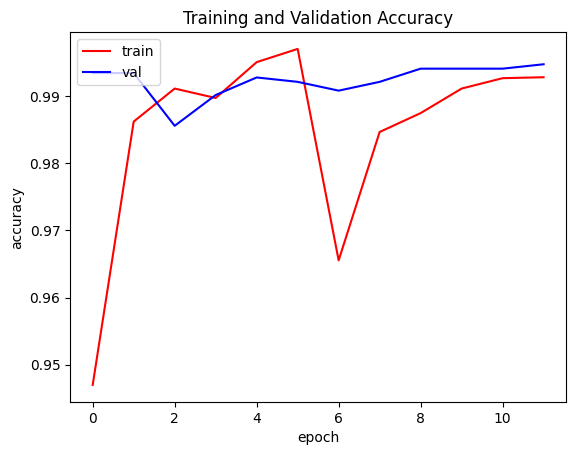

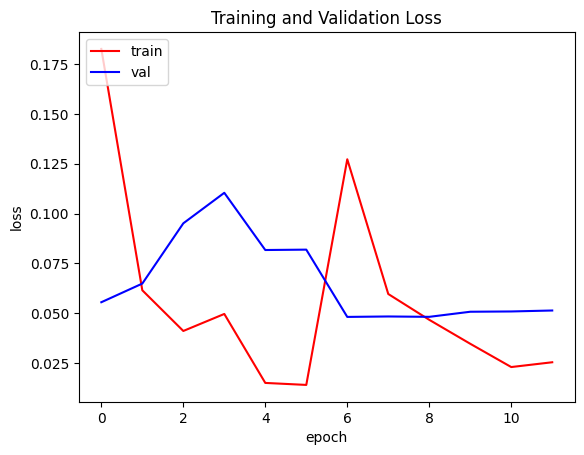

In [9]:
# Gabungkan history dari kedua tahap pelatihan
history_head_df = pd.DataFrame(history_head.history)
history_finetune_df = pd.DataFrame(history_finetune.history)
full_history_df = pd.concat([history_head_df, history_finetune_df], ignore_index=True)

# Menampilkan grafik hasil akurasi dan loss 
acc = full_history_df['accuracy']
val_acc = full_history_df['val_accuracy']
loss = full_history_df['loss']
val_loss = full_history_df['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

E0000 00:00:1751974938.668328      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751974938.818033      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 93s 49ms/step


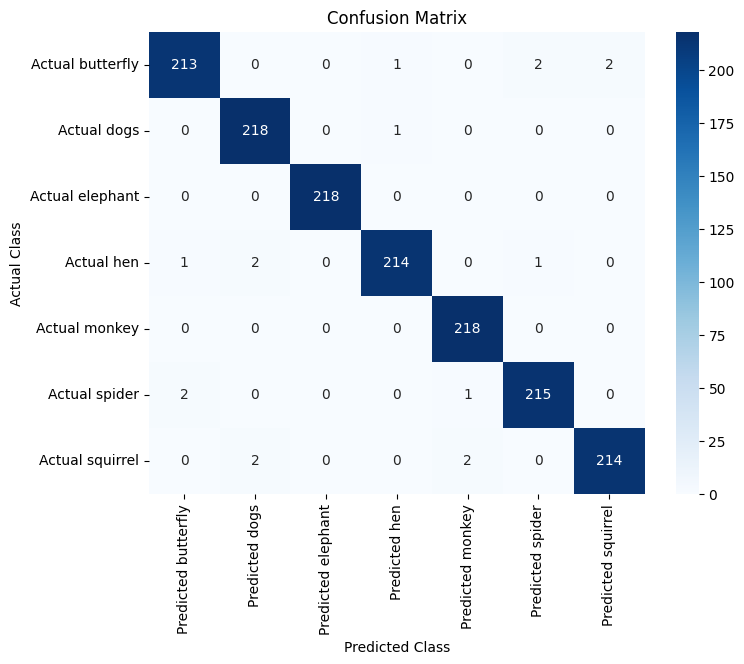


Classification Report:
              precision    recall  f1-score   support

   butterfly     0.9861    0.9771    0.9816       218
        dogs     0.9820    0.9954    0.9887       219
    elephant     1.0000    1.0000    1.0000       218
         hen     0.9907    0.9817    0.9862       218
      monkey     0.9864    1.0000    0.9932       218
      spider     0.9862    0.9862    0.9862       218
    squirrel     0.9907    0.9817    0.9862       218

    accuracy                         0.9889      1527
   macro avg     0.9889    0.9889    0.9889      1527
weighted avg     0.9889    0.9889    0.9889      1527



In [10]:
# Menampilkan confusion matrix
test_generator.reset()

preds = model.predict(test_generator, steps=len(test_generator), verbose=1)
pred_labels = np.argmax(preds, axis=1)  

# Ground truth
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())  

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=[f'Actual {c}' for c in class_names],
                        columns=[f'Predicted {c}' for c in class_names])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

## Konversi Model

In [11]:
!pip install tensorflowjs
import tensorflowjs as tfjs
import os

# Direktori utama untuk menyimpan semua format model (savedmodel, tf.lite, dan tf.js)
OUTPUT_DIR = '/kaggle/working/convert_model/'
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

# Simpan ke Format SavedModel
SAVEDMODEL_PATH = os.path.join(OUTPUT_DIR, 'saved_model')
model.export(SAVEDMODEL_PATH)

print("Penyimpanan SavedModel berhasil.")

# Mengonversi dan menyimpan ke format tflite
TFLITE_PATH = os.path.join(OUTPUT_DIR, 'model.tflite')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print("Konversi TFLite berhasil.")


# Mengonversi dan menyimpan ke format TensorFlow.js 
TFJS_PATH = os.path.join(OUTPUT_DIR, 'tfjs_model')
tfjs.converters.save_keras_model(model, TFJS_PATH)

print("Konversi TensorFlow.js berhasil.")


# Meyimpan ke dalam format ZIP
ZIP_PATH = shutil.make_archive('converted_model_all', 'zip', OUTPUT_DIR)

print("Proses Penyimpanan dan Koversi telah selesai")
for item in os.listdir(OUTPUT_DIR):
    print(f"- {item}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

Saved artifact at '/kaggle/working/convert_model/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='keras_tensor_814')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  133110769322512: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133110769320784: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133111439678096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133111439679248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133111439678864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133111439677136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133111439677712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133111439679824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133111439682320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133111439681168: TensorSpec(shape=(),

W0000 00:00:1751975228.201152      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1751975228.201211      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1751975228.795974      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Konversi TFLite berhasil.
failed to lookup keras version from the file,
    this is likely a weight only file
weight normalization/count with shape () and dtype int64 was auto converted to the type int32
Konversi TensorFlow.js berhasil.
Proses Penyimpanan dan Koversi telah selesai
- saved_model
- tfjs_model
- model.tflite


## Inference

Proses Inference dilakukan dengan menggunakan model yang disimpan dengan format savedmodel 

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


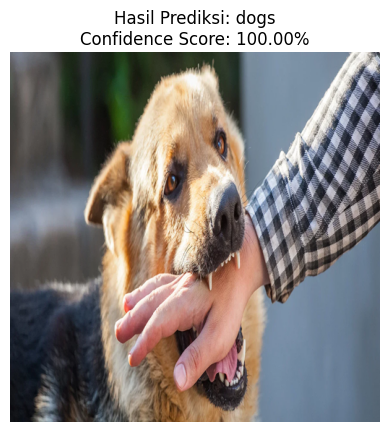

In [12]:
import requests
from keras.layers import TFSMLayer
from tensorflow.keras.preprocessing import image
from io import BytesIO

# Load SavedModel
SAVEDMODEL_PATH = '/kaggle/working/convert_model/saved_model'  
IMG_SIZE = (512, 512)

loaded_model = Sequential([
    TFSMLayer(SAVEDMODEL_PATH, call_endpoint="serving_default")
])

# Menyiapkan gambar untuk proses inferensi 
IMAGE_URL = 'https://images-1.eucerin.com/~/media/hansaplast/local/id/pdp%202023/artikel%20kv/june/new%20article/2/desktop.webp'

# Unduh gambar dari URL
response = requests.get(IMAGE_URL)
img = Image.open(BytesIO(response.content)).convert('RGB')
img = img.resize(IMG_SIZE)

# Konversi ke array
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

# Preprocess dan prediksi
preprocessed_img = preprocess_input(img_batch)
predictions = loaded_model.predict(preprocessed_img)

# Ambil hasil prediksi
pred_array = list(predictions.values())[0]  # Ambil array dari dictionary
predicted_class_index = np.argmax(pred_array[0])
confidence_score = np.max(pred_array[0])

# Label kelas dari training generator
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Tampilkan hasil
plt.imshow(img)
plt.title(f"Hasil Prediksi: {predicted_class_name}\nConfidence Score: {confidence_score:.2%}")
plt.axis('off')
plt.show()

### Model mampu menampilkan hasil prediksi berdasarkan gambar yang diinputkan dimana model dapat mengklasifikasikan 7 jenis hewan melalui gambar (spider, butterfly, hen, elephant, dogs, monkey, squirrel)